# Higher-order behaviors — example notebook

Code supporting the analysis presented in the paper "Cross-order induced behaviors in contagion dynamics on higher-order networks" [1].

This notebook contains an example of extracting measures of HOB from contagion dynamics. It involves:
- Generating a random simplicial compex (from a Erdos-Renyi-like hypergraph)
- Running simplicial SIS model on top of it
- Extracting the measures of HOB: dynamical O-information, synergy, redundancy, and transfer entropy for different groups of nodes
- Visualizing the measures and calculating the statistical distance between simplex and clique measure distributions

This notebook relies on the auxiliary script `utils.py` provided in the [GitHub repository](https://github.com/GitKalo/induced-hob). There you can also find the `requirements.txt` file for setting up your Python environment, although it should require no special packages other than `hypergraphx`.

This notebook provides a reduced example, since the real simulations and results are more resource-demanding. Scripts and data used for the paper are available upon request.

In [1]:
# General imports
from itertools import product

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "cm"     # Set to Latex-like font, serif

import numpy as np

from hypergraphx.generation import random_hypergraph

# Import helper functions
from utils import *

## Generate random simplicial complex

We follow a procedure described by Iacopini et al. [2] and in the Supplementary Material of the main reference [1].

To generate a random simplicial complex, we start from a random hypergraph and then add all lower-order edges under each hyperedge.

To obtain some target average degrees $k^*$, we adjust the degrees (number of edges $M$) in the initial hypergraph in anticipation of the extra edges added by the downward closure.

For details, refer to the SM section "Generating random higher-order networks" of the paper [1].

In [2]:
### Network parameters

N = 200                 # Number of nodes
K_MEAN = {2: 10, 3: 2}  # Target average generalized degrees {edge_size: mean_degree}

MAX_SIZE = max(K_MEAN.keys())   # Useful constant

In [3]:
### Network generation

# Calculate adjusted number of edges given target average degrees
ms = {}
ms[3] = N*K_MEAN[3]/3
ms[2] = N*(N-1)*(K_MEAN[2]-2*K_MEAN[3])/(2*(N-1)-4*K_MEAN[3])

sc = random_hypergraph(N, ms)   # Create hypergraph with adjusted pairwise probabilities
make_hypergraph_simplicial(sc)  # Fill in lower-level edges to get a simplicial complex

# Check to make sure we have correct degrees
for size, k in K_MEAN.items() :
    print(f"Average degree size {size} --- target: {k:2d}, observed: {size*sc.num_edges(size=size)/N:.2f}")

Average degree size 2 --- target: 10, observed: 9.89
Average degree size 3 --- target:  2, observed: 2.01


In [4]:
### Extract node groups for measuring HOBs later

random  = get_random_groups_hgx(sc, MAX_SIZE, n_groups=100) # Sets of random nodes
cliques = get_cliques_hgx(sc, MAX_SIZE, n_groups=100)       # Cliques
simplex = sc.get_edges(size=MAX_SIZE)                       # Simpleces

# Create sorted list of all groups — acts as "ground truth" for group index masking later
groups = sorted(set(random) | set(cliques) | set(simplex))

print(len(groups), 'groups:')
print(len(random), 'random groups')
print(len(cliques), 'cliques')
print(len(simplex), 'simplexes')

334 groups:
100 random groups
100 cliques
134 simplexes


## Run simplicial SIS dynamics

We employ the simplicial extension of the Susceptible-Infected-Susceptible contagion model, as described in Iacopini et al. [2] and SM Section "Numerical simulations of the contagion dynamics" of the main reference [1].

In [5]:
### Simulation parameters

MU = 0.8                    # Recovery rate
LAMS = np.arange(1, 11)     # Desired values of rescaled infectivity

# Calculate mean-field critical infection rate (beta) for each edge size
BETAS_C = {size: MU/k_mean for size, k_mean in K_MEAN.items()}

# Get infection rate for simulation based on critical value and rescaled infectivity
BETAS = {
    2: np.minimum(1, BETAS_C[2]*LAMS), 
    3: [BETAS_C[3]]     # For this example, we fix beta for 2-simpleces to reduce computation time.
}
# You can use the full range of betas for all sizes by uncommenting the line below:
# BETAS = {size: np.minimum(1, b_c*LAMS) for size, b_c in BETAS_C.items()}

for size, betas in BETAS.items() :
    print(f"Size {size} betas: {betas}")

T_MAX = 10**4   # Time steps for simulation (= number of samples)
# Should be at least 10^4 to see a clear difference between groups

Size 2 betas: [0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.64 0.72 0.8 ]
Size 3 betas: [0.4]


In [6]:
### Run dynamics

#########                                              #########
# Should take about a minute for T_MAX=10^4 on a modern laptop #
#########                                              #########

# Container for results
# Dimensions are betas at different edge sizes, time steps, and number of nodes
res = np.zeros((len(BETAS[2]), len(BETAS[3]), T_MAX, N), dtype='int8')

# Run for each value of beta
for i_b2, b2 in enumerate(BETAS[2]) :
    for i_b3, b3 in enumerate(BETAS[3]) :
        betas = {2: b2, 3: b3}
        res[i_b2, i_b3] = run_sis_sync_hgx(sc, betas, MU, init=0.3, t_max=T_MAX)

res

array([[[[0, 1, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 1, 0],
         [0, 1, 0, ..., 0, 1, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 1, 0, 0],
         ...,
         [1, 1, 0, ..., 1, 0, 1],
         [0, 1, 1, ..., 0, 0, 1],
         [1, 0, 0, ..., 1, 1, 0]]],


       [[[1, 0, 1, ..., 1, 0, 0],
         [1, 0, 1, ..., 1, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 1, 0, 0],
         [0, 1, 0, ..., 1, 1, 1],
         [0, 0, 1, ..., 1, 0, 0]]],


       ...,


       [[[0, 1, 0, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 1, 1],
         [0, 1, 1, ..., 1, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 1],
         [0, 1, 0, ..., 1, 1, 0],
         [1, 0, 1, ..., 0, 1, 1]]],


       [[[1, 0, 0, ..., 0, 1, 0],
         [0, 1, 1, ..., 0, 0, 1],
         [1, 0, 1, ..., 1, 1, 

## Extract measures of HOB

We extract the following measures of higher-order behavior (HOB), all described in the main refernce [1]:
- dynamical O-information $d\Omega$
- redundancy $\mathcal{R}$
- synergy $\mathcal{S}$
- unique information $\mathcal{U}$
- mutual information (multivariate transfer entropy) $\mathcal{I}$
- pairwise transfer entropy $\mathcal{T}$

The important functions for calculating these measures are in the `utils.py` supporting script.

To keep the results organized, the strategy is to store the computed measures for all groups in one multi-dimensional Numpy array for each measure, and later use masks to do group-based extraction.

In [7]:
### Compute information measures for each group

# Define containers for measures
# Dimensions reflect the fact that we measure
# at different values of beta and for each node as target
measures = {
    'dO'  : np.zeros((len(BETAS[2]), len(BETAS[3]), len(groups), MAX_SIZE), dtype=float),
    'red' : np.zeros((len(BETAS[2]), len(BETAS[3]), len(groups), MAX_SIZE), dtype=float),
    'syn' : np.zeros((len(BETAS[2]), len(BETAS[3]), len(groups), MAX_SIZE), dtype=float),
    'unq' : np.zeros((len(BETAS[2]), len(BETAS[3]), len(groups), MAX_SIZE, MAX_SIZE-1), dtype=float),  # Pairwise measure
    'mi'  : np.zeros((len(BETAS[2]), len(BETAS[3]), len(groups), MAX_SIZE), dtype=float),
    'te'  : np.zeros((len(BETAS[2]), len(BETAS[3]), len(groups), MAX_SIZE, MAX_SIZE-1), dtype=float),  # Pairwise measure
}

# Create helper dictionary that gives us for index i all indexes except i
SOURCES_FOR_TARGET = []
for target in range(3) :
    sources = list(range(3))
    sources.remove(target)
    SOURCES_FOR_TARGET.append(sources)

# Go over all beta indices
for i_b2, i_b3 in product(range(len(BETAS[2])), range(len(BETAS[3]))) :
    print(f"Calculating measures for beta 2: {BETAS[2][i_b2]:.2f}, beta 3: {BETAS[3][i_b3]:.2f}")
    # Go over all groups (random, clique, simplex)
    for i_g, group in enumerate(groups) :
        # Get infection series for nodes in group
        inf_group = res[i_b2,i_b3][:,group]

        # Get joint probability distribution for nodes in group and their one-step history
        p_joint_all = get_p_joint_all(inf_group)

        # Go оver all nodes as targets
        for t in range(3) :
            # Create source index list
            s = SOURCES_FOR_TARGET[t]

            # Calculate dO-info
            p_target_hist = np.sum(p_joint_all, axis=tuple(s))    # Marginalize over source current state
            p_target_hist = np.transpose(p_target_hist, (0, *[1+i for i in s], 1+t))  # Place target history at the end
            # p_target_hist = np.moveaxis(p_target_hist, 1+t, -1)  # Place target history at the end
            measures['dO'][i_b2,i_b3,i_g,t] = dO(p_target_hist)

            # Calculate PID atoms and MI (conditioned on target history)
            red, mis_pw = redundancy(p_target_hist, return_pw_mis=True)
            syn, mi_all = synergy(p_target_hist, return_mi=True)
            measures['red'][i_b2,i_b3,i_g,t] = red
            measures['syn'][i_b2,i_b3,i_g,t] = syn
            measures['unq'][i_b2,i_b3,i_g,t] = [mi - red for mi in mis_pw]
            measures['mi'][i_b2,i_b3,i_g,t] = mi_all

            # Calculate pairwise TE between each source and target
            p1 = np.sum(p_target_hist, axis=1)  # Marginalize further over source 1
            te1 = cmi(p1, n=1)
            p2 = np.sum(p_target_hist, axis=2)  # Marginalize further over source 2
            te2 = cmi(p2, n=1)
            measures['te'][i_b2,i_b3,i_g,t] = (te1, te2)

measures

Calculating measures for beta 2: 0.08, beta 3: 0.40
Calculating measures for beta 2: 0.16, beta 3: 0.40
Calculating measures for beta 2: 0.24, beta 3: 0.40
Calculating measures for beta 2: 0.32, beta 3: 0.40
Calculating measures for beta 2: 0.40, beta 3: 0.40
Calculating measures for beta 2: 0.48, beta 3: 0.40
Calculating measures for beta 2: 0.56, beta 3: 0.40
Calculating measures for beta 2: 0.64, beta 3: 0.40
Calculating measures for beta 2: 0.72, beta 3: 0.40
Calculating measures for beta 2: 0.80, beta 3: 0.40


{'dO': array([[[[-7.31936989e-04,  4.44547635e-04, -2.19898205e-04],
          [-6.78944418e-04, -6.82403072e-04, -4.85990308e-05],
          [-1.12237224e-04, -3.88447579e-04, -2.79520951e-04],
          ...,
          [-8.74672246e-04,  3.97814395e-04,  4.65121413e-04],
          [-4.23004465e-05, -1.19215962e-04, -7.20857533e-05],
          [-4.39743593e-04, -1.80421829e-04,  6.84544499e-05]]],
 
 
        [[[-2.82968147e-03, -6.48008086e-03, -1.63656015e-03],
          [-2.66713484e-05, -4.74333961e-04, -3.62041524e-04],
          [-2.56208907e-04, -3.86949650e-04, -4.77616673e-04],
          ...,
          [-2.00060683e-03, -4.08386077e-03, -3.56434841e-03],
          [-4.62861135e-05, -3.41341265e-06, -2.59900448e-04],
          [-1.85482787e-04, -2.05755528e-04, -3.03615448e-05]]],
 
 
        [[[-1.26822404e-03, -6.04236742e-03, -1.40215879e-03],
          [-1.10252163e-04, -1.55887950e-05, -1.40804093e-04],
          [-1.21502322e-04, -1.25358778e-04, -9.71756763e-06],
       

## Explore measure distributions

Below we plot some of the distributions and their mean values depending on the infection parameters of the simplicial SIS model. 

We do this for $d\Omega$, but the code can easily be adapted to explore other measures.

In [8]:
### Define masks for each type of group

mask_random  = np.array([group in random for group in groups])
mask_clique  = np.array([group in cliques for group in groups])
mask_simplex = np.array([group in simplex for group in groups])

# The masks are used for selecting the correct groups from the full data array via Numpy masking (indexing using a boolean array)
# A mask is basically a boolean array with True values indicating the positions in the main array that correspond to the given class (group).

In [9]:
### Get average of measures over nodes as targets

measures_avg = {
    label : np.mean(data, axis=tuple(range(3, data.ndim))) for label, data in measures.items()
}

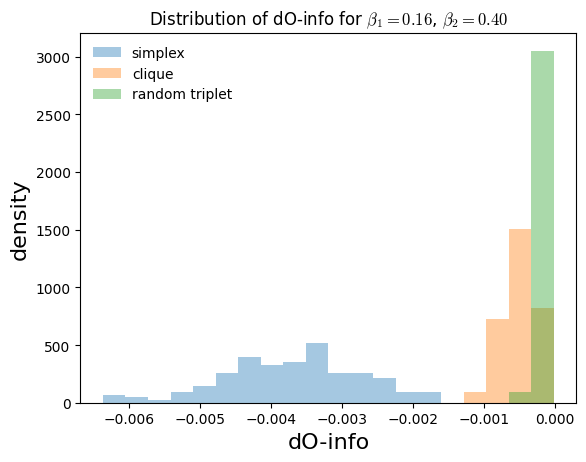

In [10]:
### Plot distribution of measures at single parameter point

betas_idx = (1, 0)              # Select paramter point
measure = measures_avg['dO']    ##### Edit here to see different measures #####

bin_range = min(measure[betas_idx]), max(measure[betas_idx])
plt.hist(measure[betas_idx][mask_simplex], density=True, range=bin_range, bins=20, alpha=0.4, label='simplex');
plt.hist(measure[betas_idx][mask_clique],  density=True, range=bin_range, bins=20, alpha=0.4, label='clique')
plt.hist(measure[betas_idx][mask_random],  density=True, range=bin_range, bins=20, alpha=0.4, label='random triplet');
plt.legend(frameon=False);
plt.xlabel('dO-info', fontsize=16);
plt.ylabel('density', fontsize=16);
plt.title(f"Distribution of dO-info for $\\beta_1={BETAS[2][betas_idx[0]]:.2f}$, $\\beta_2={BETAS[3][betas_idx[1]]:.2f}$");

<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
/var/folders/xp/mdkzlytn4qv_lz4v46jhdptw0000gn/T/ipykernel_10677/1490098527.py:11: SyntaxWarning: invalid escape sequence '\O'
  plt.ylabel('$\\langle d\Omega \\rangle$', fontsize=16)


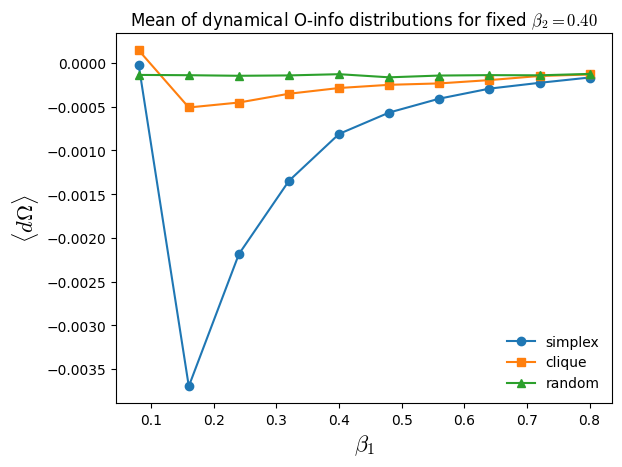

In [11]:
### Plot mean of measures as funciton of pairwise beta

means_simplex = [np.mean(measure[i_b2, 0][mask_simplex]) for i_b2 in range(len(BETAS[2]))]
means_clique = [np.mean(measure[i_b2, 0][mask_clique]) for i_b2 in range(len(BETAS[2]))]
means_random = [np.mean(measure[i_b2, 0][mask_random]) for i_b2 in range(len(BETAS[2]))]

plt.plot(BETAS[2], means_simplex, marker='o', label='simplex')
plt.plot(BETAS[2], means_clique, marker='s', label='clique')
plt.plot(BETAS[2], means_random, marker='^', label='random')
plt.xlabel(f'$\\beta_1$', fontsize=16)
plt.ylabel('$\\langle d\Omega \\rangle$', fontsize=16)
plt.title(f'Mean of dynamical O-info distributions for fixed $\\beta_2={BETAS[3][0]:.2f}$')
plt.legend(frameon=False);

## Calculate statistical distance between distributions

As in the main reference [1], below we use the statistical distance $\delta(P^s,P^c)=\frac{1}{2}\sum_x |P^s(x) - P^c(x)|$ between the measure distributions for simpleces and cliques to characterize the extent of higher-order behaviors in the groups.

In [12]:
### Get statistical distance between simplex and clique distributions at each beta value

n_bins = 30     # Define number of bins (this can affect the results in the extremes)

# Prepare container for results
betas_dim = (len(BETAS[2]), len(BETAS[3]))
deltas_simplex_clique = {
    label : np.zeros(betas_dim)
    for label in measures_avg.keys()
}

# Calculate distances (see utils.py for function definition)
for idx in product(*[range(l) for l in betas_dim]) :
    for label, delta_array in deltas_simplex_clique.items() :
        delta_array[idx] = get_stat_dist_for_index(idx, measures_avg[label], mask_simplex, mask_clique, n_bins=n_bins)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/var/folders/xp/mdkzlytn4qv_lz4v46jhdptw0000gn/T/ipykernel_10677/68837285.py:8: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\delta$', fontsize=16)


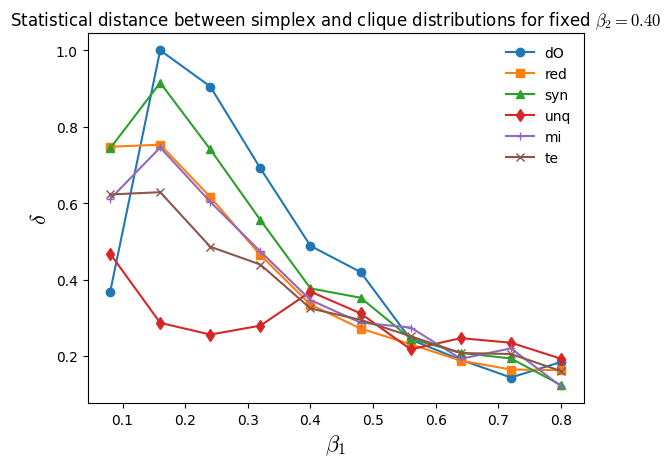

In [13]:
### Plot delta of measures as funciton of pairwise beta

markers = ['o', 's', '^', 'd', '+', 'x']
for i, (label, delta_array) in enumerate(deltas_simplex_clique.items()) :
    plt.plot(BETAS[2], delta_array, marker=markers[i], label=label)

plt.xlabel(f'$\\beta_1$', fontsize=16)
plt.ylabel('$\delta$', fontsize=16)
plt.title(f'Statistical distance between simplex and clique distributions for fixed $\\beta_2={BETAS[3][0]:.2f}$');
plt.legend(frameon=False);

# References

[1] Danovski, K., Meloni, S., & Starnini, M. Cross-order induced behaviors in contagion dynamics on higher-order networks. ...

[2] Iacopini, I., Petri, G., Barrat, A. & Latora, V. Simplicial models of social contagion. Nat Commun 10, 2485 (2019).